In [20]:
import xarray as xr 
import numpy as np
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import pandas as pd
import dask.array as da
import glob 
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [21]:


cluster = SLURMCluster(
    job_name="climt1",          # --job-name
    cores=16,                     # Number of cores per task (adjust if needed)
    processes=16,                 # One process per task
    memory="100GB",               # --mem
    walltime="01:00:00",         # --time
    queue="med",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)



/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43087 instead
  warnings.warn(


In [22]:

cluster.scale(4)

client = Client(cluster)

In [23]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:43087/status,
Dashboard: http://10.42.239.61:43087/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:40439,Workers: 0
Dashboard: http://10.42.239.61:43087/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [24]:
era_dsets = '/home1/nalex2023/Datasets/era5_manus/'

era_files = glob.glob(era_dsets + '*.nc')

era_test = xr.open_dataset(era_files[0],chunks='auto').sel(pressure_level=1000)#.roll(valid_time=10)



In [19]:
cluster.close()

In [25]:
era_test

<xarray.Dataset> Size: 856MB
Dimensions:         (valid_time: 744, latitude: 41, longitude: 1169)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 6kB 2003-10-01 ... 2003-10-31...
    pressure_level  float64 8B 1e+03
  * latitude        (latitude) float64 328B 5.0 4.75 4.5 ... -4.5 -4.75 -5.0
  * longitude       (longitude) float64 9kB -141.0 -140.8 -140.5 ... 150.8 151.0
    expver          (valid_time) <U4 12kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    z               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(248, 11, 390), meta=np.ndarray>
    q               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(248, 11, 390), meta=np.ndarray>
    t               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(248, 11, 390), meta=np.ndarray>
    u               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(248, 11, 390), meta=np.ndarray>
    v               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(248, 11, 390), meta=np.ndarray>
    w               (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(248, 11, 390), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-25T13:12 GRIB to CDM+CF via cfgrib-0.9.1...

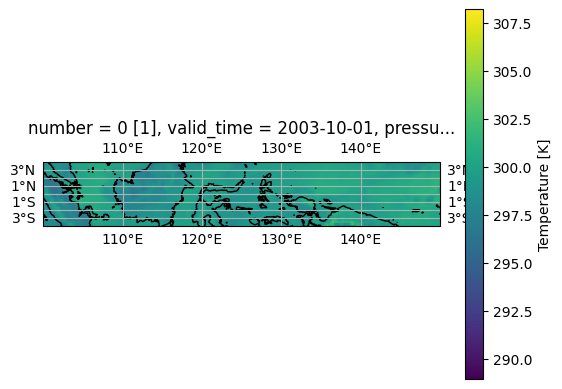

In [26]:
fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
era_test.isel(valid_time=0).t.plot(ax=ax)
ax.coastlines()
#ax.set_extent([-180,180,-90,90])
# maritime boundaries
ax.set_extent([100,150,-4,4])

grid = ax.gridlines(draw_labels=True)

In [27]:

era_test_var = era_test['t'].compute()


lon_wise_dat = []



In [28]:
lon_wise_dat = []
times_list = []

for ii in era_test_var['longitude']:
    selected_data = era_test_var.sel(longitude=ii)
    new_time = selected_data['valid_time'] + pd.Timedelta(ii.values/15,unit='h')
    new_dset = xr.DataArray(selected_data.values,dims=['time','latitude'],coords={'time':new_time.values,
                                                                                         'latitude':selected_data['latitude']})
    
    #new_dset['time'] = new_dset['time']
    new_time = [new_time]
    lon_wise_dat.append(new_dset)


In [14]:

lat_lists = []
for kk in lon_wise_dat:
    times_list.append(kk['time'])
    lat_lists.append(kk['latitude'])


In [15]:
# convert each array to a dask array

dask_arrays = [da.from_array(data, chunks=data.shape) for data in lon_wise_dat]


#stack the dask arrays along the time dimension

stacked = da.stack(dask_arrays, axis=0,allow_unknown_chunksizes=True)

stacked = stacked.map_blocks(lambda x: x, dtype=stacked.dtype)

In [1]:

final_dset = xr.combine_nested(lon_wise_dat,concat_dim='longitude')

final_dset_new = final_dset.resample(time='1h').mean()

final_dset_new['longitude'] = era_test_var['longitude']

NameError: name 'xr' is not defined

In [92]:
final_dset_new = final_dset.resample(time='1h').mean()

KeyboardInterrupt: 

In [78]:
final_dset_new['longitude'] = era_test_var['longitude']



TypeError: Delayed objects are immutable

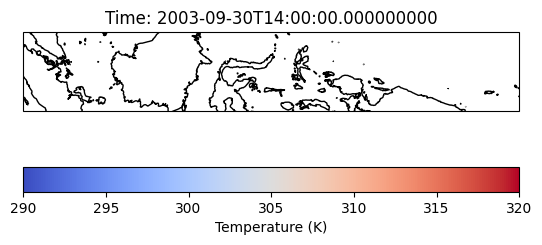

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.animation import FuncAnimation

# Assuming final_dset_new is a DataArray or Dataset with a time dimension
# and that it has a method to plot itself on the given axis

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    cs = final_dset_new.isel(time=frame).T.plot(ax=ax, transform=ccrs.PlateCarree(),add_colorbar=False,
                                                cmap='coolwarm',vmin=280,vmax=320)
    ax.set_title(f'Time: {final_dset_new.isel(time=frame).time.values}')
    ax.coastlines()
    ax.set_extent([100,150,-4,4])
    

# add colorbar
cs = final_dset_new.isel(time=0).T.plot(ax=ax, transform=ccrs.PlateCarree(),add_colorbar=False,
                                                cmap='coolwarm',vmin=290,vmax=320)

# add colorbar

cbar = plt.colorbar(cs, ax=ax, orientation='horizontal', label='Temperature (K)')

# Create the animation
ani = FuncAnimation(fig, update, frames=48, repeat=False)

# Display the animation

from IPython.display import HTML
HTML(ani.to_jshtml())

In [1]:
era_test_var

NameError: name 'era_test_var' is not defined

In [36]:
import xarray as xr
import pandas as pd
import dask
from dask import delayed, compute

era_test_var = era_test['t']

# Define a function to convert data to longitude-wise solar time (LST)


# Ensure chunks are consistent along the `valid_time` dimension
era_test_var = era_test_var.unify_chunks()

# Define a delayed function to apply the conversion function
@delayed
def process_longitude(ii):
    selected_data = era_test_var.sel(longitude=ii)
    new_time = selected_data['valid_time'] + pd.Timedelta(ii/15,unit='h')
    new_dset = xr.DataArray(selected_data.values,dims=['time','latitude'],coords={'time':new_time.values,
                                                                                         'latitude':selected_data['latitude']})

    return new_dset


In [46]:
import xarray as xr
import pandas as pd
import dask
from dask import delayed, compute
import dask.array as da

era_test_var = era_test['t']

# Ensure chunks are consistent along the `valid_time` dimension
era_test_var = era_test_var.unify_chunks()

# Define a delayed function to apply the conversion function
@delayed
def process_longitude(ii):
    selected_data = era_test_var.sel(longitude=ii)
    new_time = selected_data['valid_time'] + pd.Timedelta(ii / 15, unit='h')
    new_dset = xr.DataArray(
        selected_data.values,
        dims=['valid_time', 'latitude'],
        coords={'valid_time': new_time.values, 'latitude': selected_data['latitude']}
    )
    return new_dset,new_time




In [49]:
# Create a list of delayed tasks
tasks = [process_longitude(ii)[0] for ii in era_test_var['longitude'].values]

# Compute the delayed tasks
lon_wise_dat = compute(*tasks)

# Convert the list of DataArrays to a Dask array
dask_arrays = [da.from_array(data, chunks=data.shape) for data in lon_wise_dat]


In [43]:
concated_data = da.stack(dask_arrays,axis=0)

In [45]:
# now back to xarray



final_dset = xr.DataArray(concated_data,dims=['longitude','valid_time','latitude'],
                          coords={'longitude':era_test_var['longitude'],
                                  'valid_time':era_test_var['valid_time'],
                                  'latitude':era_test_var['latitude']})

final_dset

<xarray.DataArray 'stack-c60675099718cbba878f6a4febc7198e' (longitude: 1169,
                                                            valid_time: 744,
                                                            latitude: 41)> Size: 143MB
dask.array<stack, shape=(1169, 744, 41), dtype=float32, chunksize=(1, 744, 41), chunktype=numpy.ndarray>
Coordinates:
  * longitude   (longitude) float64 9kB -141.0 -140.8 -140.5 ... 150.8 151.0
  * valid_time  (valid_time) datetime64[ns] 6kB 2003-10-01 ... 2003-10-31T23:...
  * latitude    (latitude) float64 328B 5.0 4.75 4.5 4.25 ... -4.5 -4.75 -5.0

In [61]:

# Combine the results along the longitude dimension
final_dset = xr.combine_nested(lon_wise_dat, concat_dim='longitude')

# Resample the dataset to hourly means
final_dset_new = final_dset.resample(valid_time='1h').mean()

# Assign the original longitude values back to the dataset
final_dset_new['longitude'] = era_test_var['longitude']

# Output the final dataset
final_dset_new

KeyError: 'valid_time'